In [1]:
import numpy as np
import glob
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Computes the camera calibration matrix 
# and distortion coefficients given a set of chessboard images.
mtx = None
dst = None

def calibrate_camera(path, nx=8, ny=6):
    print('calibrating camera............')
    imagelist = glob.glob(path)
    nx = nx
    ny = ny
    objpoints = [] #3D points of real object (x,y,z) (0,0,0) - (8,5,0)
    imgpoints = [] #2D points of the chessboard image 

    #prepare object points like (0,0,0)
    objp = np.zeros((nx*ny,3), np.float32) #3-dimensional points

    #populate with coords using mgrid
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x,y coordinates
    objp.shape

    j = 0
    for i in imagelist:
        
        img = mpimg.imread(i)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners are found, add object points and image points
        if ret == True:
            #print('found lines')
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            #plt.imshow(img)
            j+=1

    print("detected lines for {}/{}".format(j,len(imagelist)))
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    cv2.destroyAllWindows()
    return mtx, dist


# Apply a distortion correction to raw images.
def undistort_image(image):
    global mtx
    global dst
    
    if(mtx is None and dst is None):
        mtx, dst = calibrate_camera('camera_cal/calibration*.jpg',9,6)
        
    return cv2.undistort(image, mtx, dst, None, mtx)


# Apply a perspective transform to rectify binary image ("birds-eye view").
def perspective_transform(image, src, dst):
    img_size = (image.shape[1], image.shape[0])
  
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    #warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    warped = cv2.warpPerspective(image, M, (1280, 720), flags=cv2.INTER_LINEAR)
    
    return warped, Minv

def visualize(img1,img2,img3):
    # Plot the result
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img1, cmap='gray')
    ax1.set_title('img1', fontsize=50)

    ax2.imshow(img2, cmap='gray')
    ax2.set_title('img2', fontsize=50)

    ax3.imshow(img3, cmap='gray')
    ax3.set_title('img3', fontsize=50)
    
    print("image shapes ", img1.shape, img2.shape, img3.shape)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
# first step to drawing lines on a perspective transformed binary image is splitting the line into chunks of boxes 
def draw_lines(binary_warped):
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Take a histogram of the bottom half of the warped image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    #plt.plot(histogram)
    
    # Identify where the left and right lines are in the image. Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows. Greater number will increase curve accuracy
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
       
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
       
    window_img = np.zeros_like(out_img)
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
    return result

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    if(len(img.shape)==3):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobelx = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    scaled_sobel = np.uint8(255*np.absolute(sobelx)/np.max(np.absolute(sobelx)))
    sxbinary = np.zeros_like(scaled_sobel)
    
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sxbinary

def mag_sobel_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    if(len(img.shape)==3):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
   
    abs_sobelxy = (np.absolute(sobelx)**2+np.absolute(sobely)**2)**(0.5)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
   
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

def dir_sobel_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1) Convert to grayscale
    if(len(img.shape)==3):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradient_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    # 6) Return this mask as your binary_output image
    sxbinary = np.zeros_like(gradient_dir)
    sxbinary[(gradient_dir >= thresh[0]) & (gradient_dir <= thresh[1])] = 1
   
    return sxbinary


def color_thresh(img, hls_thresh=(0, 255), hsv_thresh=(0, 255), yuv_thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #take only S channel
    s_channel = hls[:,:,2]
    hls_binary = np.zeros_like(s_channel)
    hls_binary[(s_channel > hls_thresh[0]) & (s_channel <= hls_thresh[1])] = 1
        
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #take v channel
    v_channel = hsv[:,:,2]
    hsv_binary = np.zeros_like(v_channel)
    hsv_binary[(v_channel) > hsv_thresh[0] & (v_channel <= hsv_thresh[1])] = 1
    
    
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #take v channel
    u_channel = yuv[:,:,1]
    yuv_binary = np.zeros_like(u_channel)
    yuv_binary[(u_channel) > yuv_thresh[0] & (u_channel <= yuv_thresh[1])] = 1
        
    color_binary = np.zeros_like(v_channel)
        
    color_binary[(hls_binary == 1)] = 1
    #color_binary[(hsv_binary == 1)] = 1
    #color_binary[(yuv_binary == 1)] = 1
    #color_binary[(hls_binary == 1) & (hsv_binary == 1) & (yuv_binary == 1)] = 1
    #color_binary[(hls_binary == 1) & (yuv_binary == 1)] = 1
    
    #visualize(hls_binary, hsv_binary, yuv_binary)
    #print(hls_thresh, hsv_thresh, yuv_thresh)
    
    return color_binary




In [5]:
# returns a binary image with clean lines to mark lines on 
def thresholded_binary(image):
   
    global a_thresh
    global m_thresh
    global d_thresh
    global hls_thresh
    global hsv_thresh
    global yuv_thresh
    
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=a_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=a_thresh)
    mag_binary = mag_sobel_thresh(image, sobel_kernel=ksize, thresh=m_thresh)
    dir_binary = dir_sobel_thresh(image, sobel_kernel=ksize, thresh=d_thresh)
    col_binary = color_thresh(image, hls_thresh, hsv_thresh, yuv_thresh)
    
    combined = np.zeros_like(gradx)
    
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1    
    #combined[((gradx == 1) & (grady == 1)) |  (col_binary == 1)] = 1    
    #combined[((gradx == 1) & (grady == 1))] = 1
    #combined[((mag_binary == 1) & (dir_binary == 1) | (col_binary == 1))] = 1 
    #combined[((gradx == 1) & (grady == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1
    combined[((gradx == 1) & (grady == 1)) | (col_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1    
    
    return combined

In [6]:
def pipeline(image):
    
    # Undistort an image so lines can be parallel in birds-eye-view
    undistorted = undistort_image(image)
    
    # Run through sobel and color thresholds for a clean picture with straight lines 
    binary_output = thresholded_binary(image)

    # settings to do perspective transform on binary image - automate this calculation
    #p_src = np.float32([[710, 460],[1128, 720],[210, 720],[578, 460]])
    #p_dst= np.float32([[960, 0], [960, 720], [200, 720], [200, 0]])
    
    p_src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
    p_dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

    # do a birds-eye-view perspective transform so we can draw lines
    binary_warped, Minv = perspective_transform(binary_output, p_src, p_dst)
    
    #draw lines
    lines = draw_lines(binary_warped)
    
    #Inverse perspective of lines image
    lines_inv = cv2.warpPerspective(lines, Minv, (1280, 720))
    
    #super impose lines onto the original image
    combined = cv2.addWeighted(undistorted, 1, lines_inv, 0.8, 1)
    
    #return undistorted, binary_output, binary_warped, lines, lines_inv, combined
    return combined
        
    

In [10]:
def add_mask(image, coords):
    mask = np.zeros_like(image)
    mask = cv2.fillPoly(mask, np.int32([coords]), (0,255, 0))
    return cv2.addWeighted(image, 1, mask, 0.3, 0)


image shapes  (720, 1280, 3) (720, 1280, 3) (720, 1280)


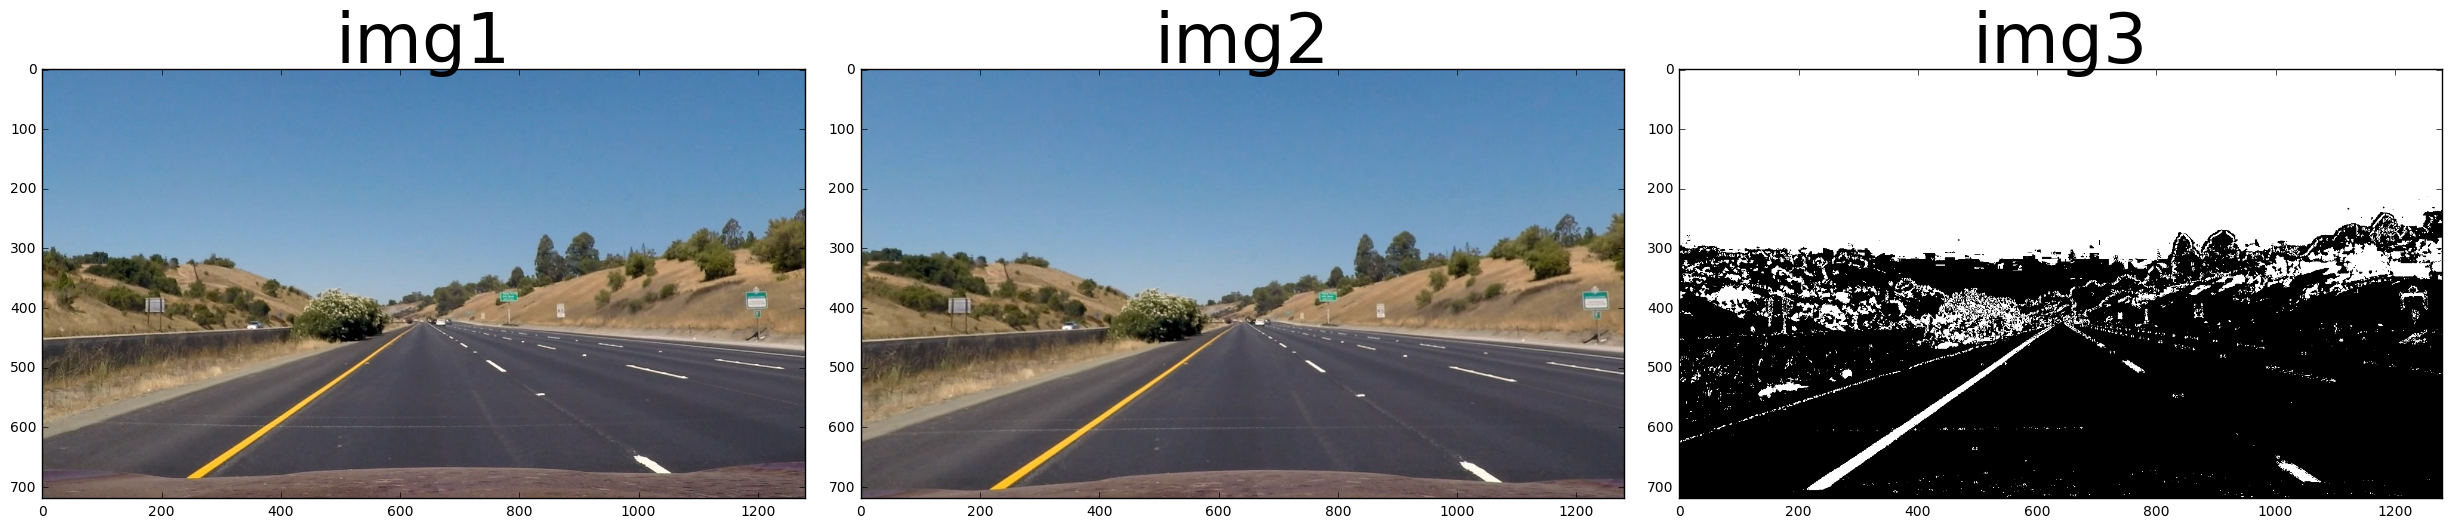

In [23]:
a_thresh = (70,200)
m_thresh = (30,100)
d_thresh = (0.1,1.3)
hls_thresh = (90, 255)
hsv_thresh = (0, 50)
yuv_thresh = (0, 50)


image = mpimg.imread('test_images/straight_lines1.jpg')
#image = VideoFileClip("test_clip.mp4").get_frame(t=0.4)
undistorted = undistort_image(image)
binary = thresholded_binary(undistorted)
visualize(image, undistorted, binary)




image shapes  (720, 1280, 3) (720, 1280, 3) (720, 1280)


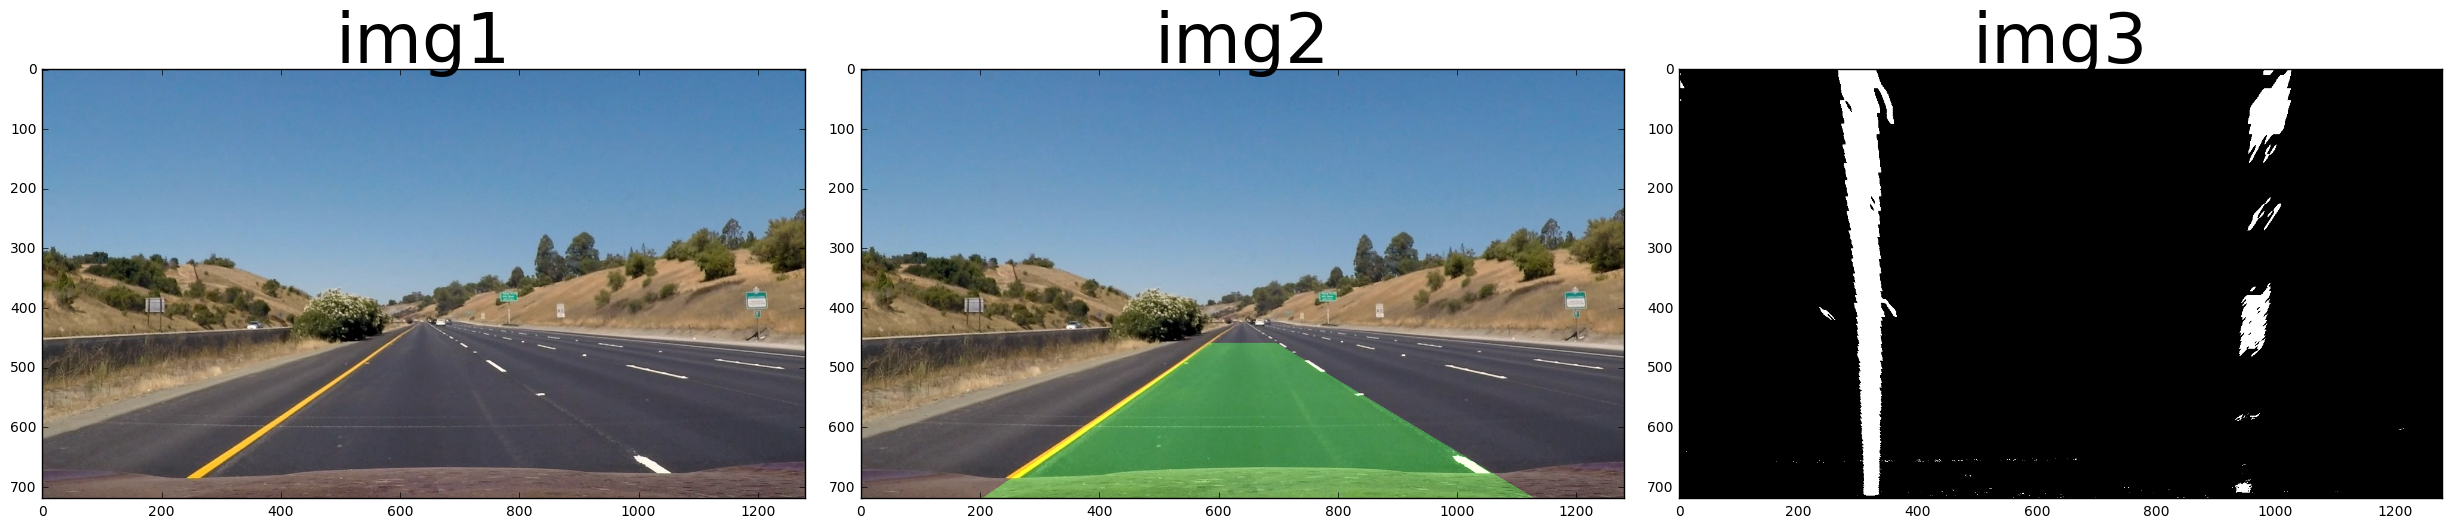

In [36]:
#persp_src = np.float32([[710, 460],[1128, 720],[210, 720],[578, 460]])
#persp_dst= np.float32([[960, 0], [960, 720], [200, 720], [200, 0]])

persp_src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
persp_dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

binary_warped, Minv = perspective_transform(binary, persp_src, persp_dst)
masked_image = add_mask(image,persp_src)

visualize(image, masked_image, binary_warped)


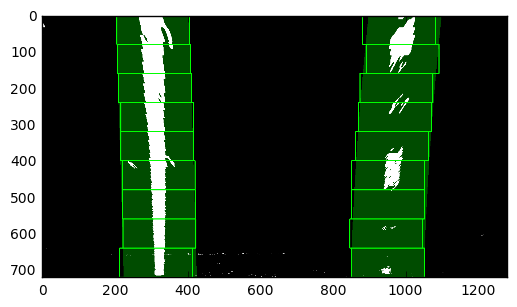

In [37]:
lines = draw_lines(binary_warped)
plt.imshow(lines, cmap='gray')

In [9]:
output_clip = "test_output.mp4"
clip1 = VideoFileClip('challenge_video.mp4')
challenge_clip1 = clip1.fl_image(pipeline)
%time challenge_clip1.write_videofile(output_clip, audio=False)

[MoviePy] >>>> Building video zzz.mp4
[MoviePy] Writing video zzz.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:57<00:00,  4.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: zzz.mp4 

Wall time: 1min 58s
